In [2]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, svm
import numpy as np
from math import sqrt
from shapleycomposition import ShapleyExplainer
from composition_stats import ilr, ilr_inv, sbp_basis, inner
from bifurc_tree import create_tree_from_sbp, init_graph, build_graph
import plotly.graph_objects as go

In [3]:
K = 13         #index of the instance you want to test in the test set
N_class = 3    #number of class, the dimension of the simplex is therefore N_class-1


#load the dataset and split into a training and testing set
data = datasets.load_iris()
(X, Y) = (data.data, data.target)
X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

#train an SVM classifier
svc_linear = svm.SVC(kernel='rbf', probability=True)
svc_linear.fit(X_train, Y_train)

#choose an Aitchison orthonormal basis by setting a sequential binary partition matrix.
#If None, the basis obtained with the gram-schmidt procedure is used
sbpmatrix=np.array([[1,-1,0],[1,1,-1]])
basis = sbp_basis(sbpmatrix)

# explain all the predictions in the test set
explainer = ShapleyExplainer(svc_linear.predict_proba, X_train, N_class, sbpmatrix=sbpmatrix,
                            names_classes=data.target_names,
                            names_features=['sep. length','sep. width','pet. length','pet. width'])
(shapley, base) = explainer.explain_instance(np.array(X_test[K]))

print("True label of the tested instance: ", end="")
print(data.target_names[Y_test[K]])

#get the model prediction for the Kth instance of the test partition
pred = svc_linear.predict_proba(X_test[K].reshape(1,-1))
print("Prediction on the simplex: ",end="")
print(pred)
ilr_pred = ilr(pred, basis=basis)
print("Prediction in the ILR space: ",end="")
print(ilr_pred)

#The sum of the base distribution and the shapley composition in the ILR space is equal to the predicted probability distribution
sum_shap_base = np.array(shapley).sum(axis=0)+base
print("Sum of the shapley composition and the base distribution in the ILR space: ", end="")
print(sum_shap_base)



True label of the tested instance: versicolor
Prediction on the simplex: [[0.00855359 0.81769494 0.17375146]]
Prediction in the ILR space: [-3.22450445 -0.59702682]
Sum of the shapley composition and the base distribution in the ILR space: [-3.22450444 -0.59702682]


In [11]:
#SUMMARIZE WITH NORM, COSINE AND INNER PRODUCTS

(norm_shapley, proj_shap_class, cos_shap_shap) = explainer.summarize()

List of the features sorted by their Shapley strength (norm of their Shapley composition):
	 pet. length: 2.2467706
	 pet. width: 0.5368538
	 sep. length: 0.1161778
	 sep. width: 0.0986827

Projection of the Shapley compositions on the class vectors:
		sep. length	sep. width	pet. length	pet. width	
setosa:   	-0.0693990	-0.0958569	-1.9503941	-0.5359346	
versicolor:	0.1153890	0.0276234	1.9410933	0.2951624	
virginica:	-0.0459900	0.0682335	0.0093008	0.2407722	

Cosine between each Shapley compositions:
		sep. length	sep. width	pet. length	pet. width	
sep. length:	1.0000000	0.3897026	0.9166649	0.6432392	
sep. width:	0.3897026	1.0000000	0.7252868	0.9558043	
pet. length:	0.9166649	0.7252868	1.0000000	0.8956381	
pet. width:	0.6432392	0.9558043	0.8956381	1.0000000	


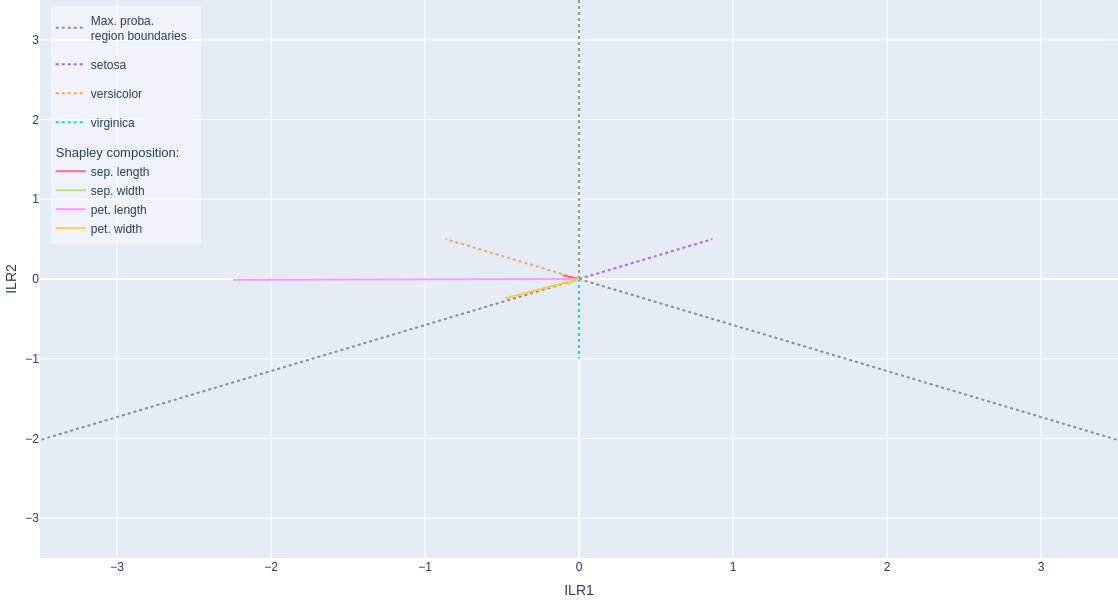

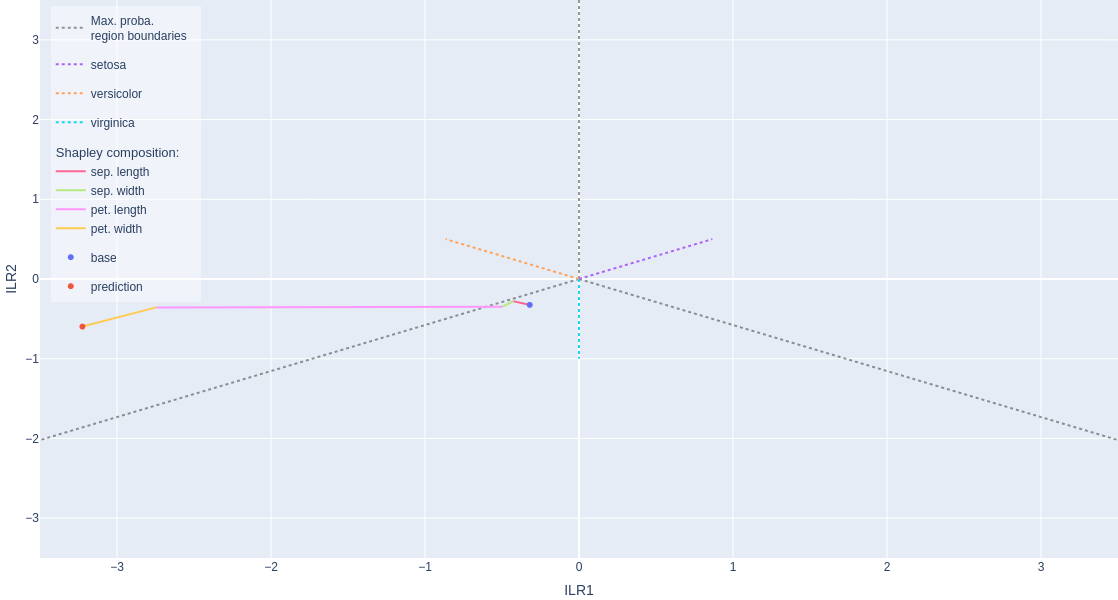

In [10]:
#PLOT the 2D ILR SPACE (CORRESPONDING TO THE CHOSEN ILR COMPONENTS LISTED IN BALANCES).
#plot range [-lim, lim]
#If shapley_sum is True, the sum of the shapley vectors are summed from the base distribution to the prediction

fig = explainer.plot_ilr_space(balances=[1, 2], lim=3.5, figsize=600)

fig = explainer.plot_ilr_space(balances=[1, 2], shapley_sum=True, lim=3.5, figsize=600)


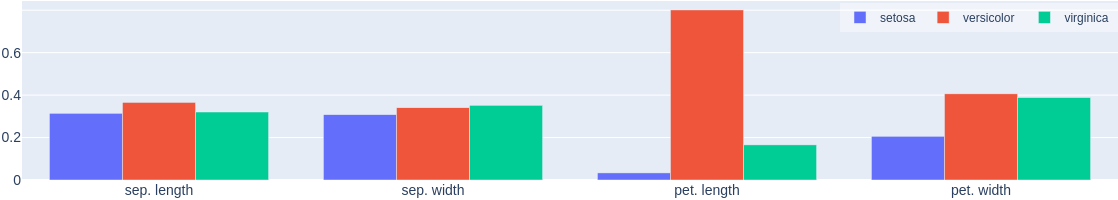

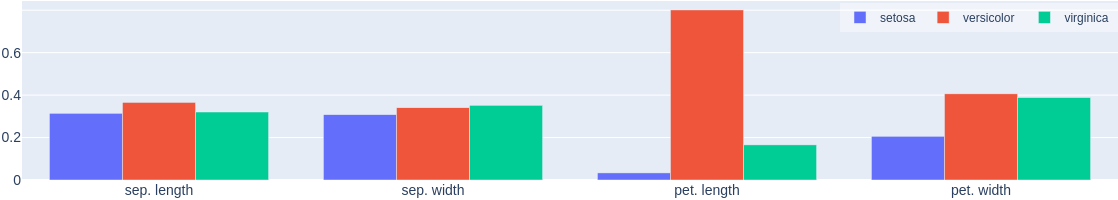

In [8]:
#Plot the Shapley compositions as histograms
explainer.shapley_histogram(figheight=200)